In [1]:
# Install required libraries
%pip install torch torchaudio transformers datasets[audio] scikit-learn numpy matplotlib 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

In [3]:
def convert_to_target(emotion):
    if emotion == 'euphoric':
        return 1
    elif emotion == 'joyfully':
        return 2
    elif emotion == 'sad':
        return 3
    elif emotion == 'surprised':
        return 4
    else:
        return -1

In [4]:
# Load dataset
audio_dataset = load_dataset(
    'TrainingDataPro/speech-emotion-recognition-dataset',
    split='train'
)

# Load CLAP model
model = ClapModel.from_pretrained('laion/larger_clap_music').to('cuda:0')
processor = ClapProcessor.from_pretrained('laion/larger_clap_music')

# Preprocess audio samples
emotions = ['euphoric', 'joyfully', 'sad', 'surprised']
sample_inputs = []
audio_embeddings = []
targets = []

SAMPLING_RATE = 48000

for emotion in emotions:
    for sample in audio_dataset[emotion]:
        sample_inputs.append(
            processor(
                audios=sample['array'],
                sampling_rate=SAMPLING_RATE,
                return_tensors='pt'
            ).to('cuda:0')
        )
        targets.append(convert_to_target(emotion))

for inputs in sample_inputs:
    audio_embeddings.append(model.get_audio_features(**inputs))
    
torch.save(audio_embeddings, 'audio_embeddings.pt')

In [5]:
# Flatten embeddings
flattened_embeddings = [embedding.view(-1) for embedding in audio_embeddings]
embedding_matrix = torch.stack(flattened_embeddings)

# Convert embeddings from tensor to numpy arrays
embedding_matrix = embedding_matrix.detach().cpu().numpy()
print(embedding_matrix.shape)
print(embedding_matrix)

(80, 512)
[[-0.0197334  -0.00249679  0.11328787 ... -0.08363502  0.04762014
   0.08813638]
 [-0.01700936 -0.00169819  0.12584828 ... -0.08392757  0.05042014
   0.0900396 ]
 [-0.01665157 -0.00179881  0.11708343 ... -0.0858629   0.04423774
   0.08991268]
 ...
 [-0.01731364 -0.00215796  0.11473525 ... -0.0838877   0.04435505
   0.08995587]
 [-0.01807118 -0.00259435  0.11262784 ... -0.08339463  0.04653695
   0.08947439]
 [-0.01466641 -0.00274683  0.1172166  ... -0.08552615  0.04621886
   0.09083286]]


In [6]:
# Train Naive-Bayes classifier
model = GaussianNB()

# Use 5-fold cross-validation
cv_results = cross_validate(
    model,
    embedding_matrix,
    targets,
    cv=10,
    return_train_score=True
)

mean_train_score = np.mean(cv_results['train_score'])
mean_test_score = np.mean(cv_results['test_score'])

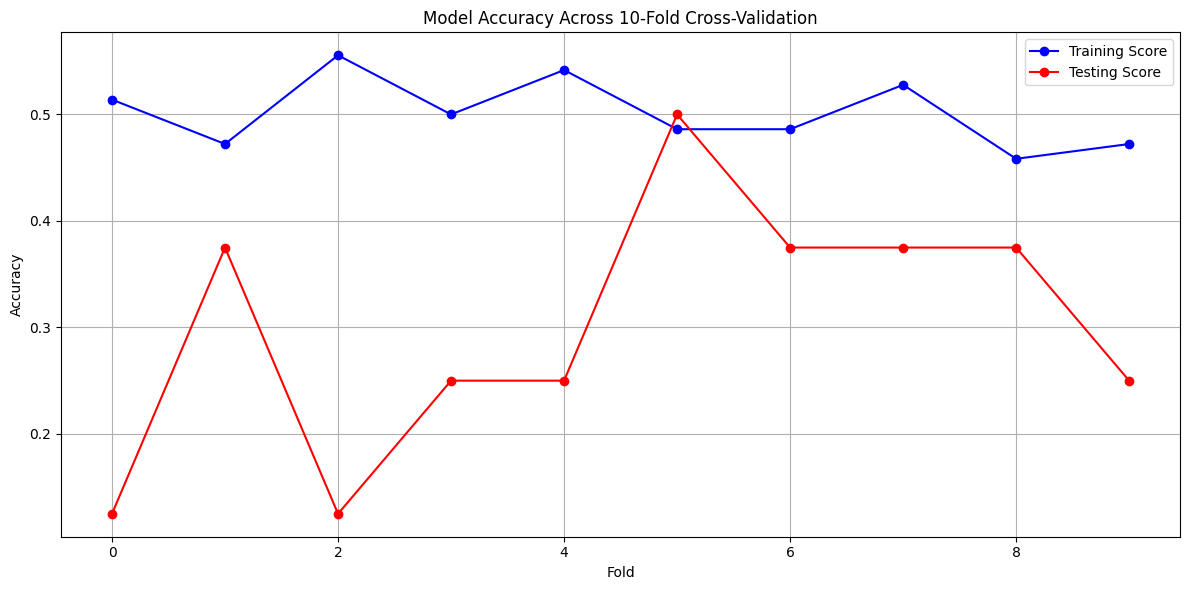

Mean Training Accuracy: 0.50139
Mean Testing Accuracy: 0.3


In [9]:
#Visualize and compare accuracy for different K values
plt.figure(figsize = (12, 6))

plt.plot(cv_results['train_score'], label='Training Score', color='blue', marker='o')
plt.plot(cv_results['test_score'], label='Testing Score', color='red', marker='o')

plt.title('Model Accuracy Across 10-Fold Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# Print average accuracy scores
print("Mean Training Accuracy:", round(mean_train_score, 5))
print("Mean Testing Accuracy:", round(mean_test_score, 5))